# Research Assignment: Postgradudate Optimisation
## By Arjun Shah (14404154), Mohammad Hassan Ihsan (24886665), Saleem Alharbi (14339461) 

### <p style="text-align: center;">Abstract</p>


This research assignment aims to compare three algorithms on their performance on a global optimisation search within the drop-wave function. 
The three algorithms that will be tested are: 
1. Steepest Descent (SD)(Cauchy) 
2. Conjugate Direction (CD)
3. Particle Swarm

The purpose of this comparison is to highlight the issue of needing an initial starting position for optimisation algorithms when looking to optimise over a complex geometric plane. The drop-wave function is a function with many steep hills and valley's, making it a good test for algorithms designed to find the global minima. However, due to these steep hills and valley's, the performance of the SD and CD algorithms becomes highly dependent upon their starting position. This is highlighted on both algorithms through a series of tests using different starting points.  

This issue is overcome in two-ways:  
Firstly, by using latin hypercube sampling to generate intitial starting position, effectively running each algorithm multiple times and taking the lowest value to be the global minima.  
Secondly, by using an algorithm that doesn't rely on an intital starting position. We use the Particle Swarm Optimisation (PSO). This algorithm does not depend on a specific intitial starting position nor does it rely on differentiation. 

A comparison is done on the performance of each:
* Steepest Descent (SD) with Latin Hypercube Sampling 
* Conjugate Direction (CD) with Latin Hypercube Sampling
* Particale Swarm Optimisation (PSO)   

They are compared on the basis of computational efficiency & accuracy. 

### Installing Required Libraries

In [1]:
from autograd import grad, jacobian
from scipy.optimize import minimize, OptimizeResult
from scipy.optimize import line_search
import autograd.numpy as np 
import autograd.numpy.linalg as la
from autograd import grad, jacobian
import pandas as pd

## Defining and Visualising the Drop-Wave Function

The Drop-Wave function is defined as follows:

\begin{equation}
f(\mathbf{x}) = -\frac{1 + \cos(12 \sqrt{x_1^2 + x_2^2})}{0.5 (x_1^2 + x_2^2) + 2}
\end{equation}

where:
\begin{align*}
\mathbf{x} &= (x_1, x_2) \\
x_1, x_2 &\in [-5.12, 5.12]
\end{align*}

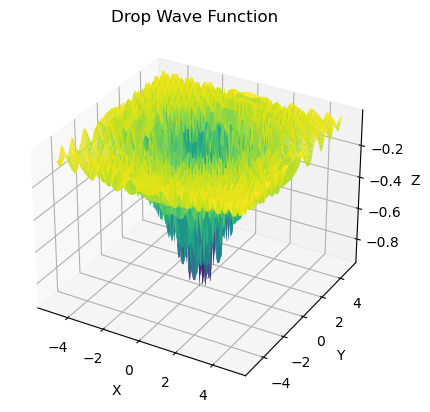

In [2]:
import numpy as np

def drop_wave(x, y):
    numerator = 1 + np.cos(12 * np.sqrt(x**2 + y**2))
    denominator = 0.5 * (x**2 + y**2) + 2
    return -numerator / denominator

# Example usage:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = drop_wave(X, Y)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Drop Wave Function')
plt.show()

We can see through the visualisation above that the drop wave function has many steep hills and concavities, making it likely that search agents can get stuck in local minima, especially if they depend on an initital starting position. 
We highlight the dependence of the steepest descent (cauchy) algorithm and conjugate direction (fletcher-reeves) algorithm on their starting positions below. 

## Defining and Implementing Steepest Descent and Conjugate Direction Algorithm

Steepest Descent algorithm is defined with the following steps:

1. Choose a starting point $x_1$ and set $k = 1$
2. If $x_k$ satisfies the stopping criterion, then stop.
3. Set $\mathbb{d} = -\nabla f(x_k)$
4. Find a minimum point $a_k$ for  $$min\;f(x_k + \alpha_k)$$ $$subject\;to$$ $$\alpha \geq 0$$
5. Set $x_{k+1} = x_k + \alpha_k\mathbb{d}_k$
5. Set $k = k + 1$ and go to Step 2

Conjugate Direction algorithm is defined with the following steps: 
1. Start with an arbitrary initial point $x_1$
2. Set $i = 1$ and $$\mathbb{d}_1 = -\nabla f(x_1)$$
3. Set $$x_{i+1} = x_i + \alpha_i\mathbb{d}_i$$ where $\alpha_i$ is a solution of the line search problem      $$minimise\;f(x_i + \alpha\mathbb{d}_i)$$
4. If the termination criterion is satisfied, then stop. Otherwise, set $$\mathbb{d}_{i+1} = -\nabla f(x_{i+1}) + \frac{||\nabla f(x_{i+1})||^2}{||\nabla f(x_{i})||^2}\mathbb{d}_i$$
5. Set $i = i+1$ and go to Step 3

# Implementing Steepest Descent and Conjugate Direction Functions
The code below implements two functions, one for steepest descent and one for conjugate direction

In [3]:
# Steepest Descent Function
def steepest_descent(fun, x0, jac, ls = line_search, maxiter = 100, amax = 1000., tol = 1.e-8 ):
  ''' Simple implementation of Steepest Descent for minimising unconstrained nonlinear function.

  Parameters: 
    fun (callable) : the function to minimise

    x0 (1D array) : initial guess

    jac (callable) : the gradient function

    ls (callable, line_search)

    maxiter(int, 100) : maximum number of iterations

    amax(float, 1000.) : max step size in line search

    tol(float, 1.e-8) : used for stopping criteria

  Return:
    res (scipy.optimize.OptimizeResult): optimal solution and value

  Note:
    Follow the style of scipy.optimize;
    scipy.optimize.line_search is used

  '''
  x_eps = tol # tolerence for convergence on delta x
  f_eps = tol # tolerence for convergence on delta f
  g_eps = tol # tolerence for convergence on norm of gradient
  x_k = x0.copy()
  f_k = fun(x_k)
  nfev = 1
  g_k = jac(x_k)
  njev = 1
  nit = 1
  res = OptimizeResult()
  n_g_k = la.norm(g_k)
  if n_g_k < g_eps:
    res.x = x_k
    res.success = True
    res.status = 0
    res.message = "norm of gradient is within tolerence"
    res.fun = f_k
    res.nfev = nfev
    res.njev = njev
    res.nit = nit

  while True:
    alpha_k, fc_k, gc_k, f_k1, _,_ = ls(fun,jac,x_k,-g_k , amax=amax)
    nfev += fc_k
    njev += gc_k
    if alpha_k == None or f_k1 == None: 
      res.x = x_k
      res.success = False
      res.status = 1
      res.message = "Line search fail: alpha or fun is None"
      res.fun = f_k
      res.nfev = nfev
      res.njev = njev
      res.nit = nit
      break

    if abs(alpha_k*n_g_k) < x_eps:
      res.x = x_k1
      res.success = True
      res.status = 0
      res.message = "change of x is within tolerence"
      res.fun = f_k1
      res.nfev = nfev
      res.njev = njev
      res.nit = nit
      break      
    
    x_k1 = x_k - alpha_k*g_k
    
    if abs(f_k - f_k1) < f_eps:
      res.x = x_k1
      res.success = True
      res.status = 0
      res.message = "change of fun is within tolerence"
      res.fun = f_k1
      res.nfev = nfev
      res.njev = njev
      res.nit = nit
      break      
    
    g_k1 = jac(x_k1)
    njev += 1
    n_g_k = la.norm(g_k1)
    if n_g_k < g_eps:
      res.x = x_k1
      res.success = True
      res.status = 0
      res.message = "norm of gradient is within tolerence"
      res.fun = f_k1
      res.nfev = nfev
      res.njev = njev
      res.nit = nit
      break      

    if nit > maxiter:
      res.x = x_k1
      res.success = False
      res.status = 0
      res.message = "Max iter reached"
      res.fun = f_k1
      res.nfev = nfev
      res.njev = njev
      res.nit = nit
      break     

    nit += 1
    x_k = x_k1
    f_k = f_k1
  return res

# Conugate Direction Function
def conjugate_direction(fun, x0, jac, ls = line_search, maxiter = 100, amax = 1000., tolerance = 1.e-8):
  ''' Simple implementation of Conjugate Direction for minimising unconstrained nonlinear function.

  Parameters: 
    fun (callable) : the function to minimise
    x0 (1D array) : initial guess
    jac (callable) : the gradient function
    ls (callable, line_search)
    maxiter(int, 100) : maximum number of iterations
    amax(float, 1000.) : max step size in line search
    tol(float, 1.e-8) : used for stopping criteria
  Return:
    res (scipy.optimize.OptimizeResult): optimal solution and value

  Note:
    Follow the style of scipy.optimize;
    scipy.optimize.line_search is used

  '''
  # step 1
  x_k = x0.copy()
  f_k = fun(x_k)
  # step 2  
  d_k = -1 * jac(x_k)
  # variable initialization
  nfev = 1
  njev = 1
  nit = 0

  while True:
    # step 3
    nit += 1
    alpha_k, fc_k, gc_k, f_k, _, _ = ls(fun, jac, x_k, d_k, amax=amax)
    nfev += fc_k
    njev += gc_k
    if alpha_k == None or f_k == None:
      success = False
      status = 1
      message = "Line search fail: alpha or fun is None"
      break
    x_prev = x_k.copy()
    x_k = x_k + alpha_k * d_k

    if nit > maxiter:
      success = False
      status = 0
      message = "Max iter reached"
      break 

    njev += 1
    g_k = jac(x_k)
    norm_g_k = la.norm(g_k)
    if norm_g_k < tolerance:
      success = True
      status = 0
      message = "norm of gradient is within tolerence"
      break
    
    # Step 4
    direction_correction = -1 * np.sign(np.inner(g_k, d_k)) # correction if d_k is ascending direction
    g_prev = jac(x_prev)
    beta_k = np.sum(g_prev**2) / np.sum(g_k**2)
    d_k = -1 * g_k + direction_correction * beta_k * d_k

  res = OptimizeResult()
  res.x = x_k
  res.success = True
  res.status = 0
  res.message = message
  res.fun = f_k
  res.nfev = nfev
  res.njev = njev
  res.nit = nit
  return res

## Testing Steepest Descent and Conjugate Direction Optimisation on Drop Wave function
We test each algorithm on the drop-wave function with a variety of starting positions chosen arbitrarily to highlight the dependence on initial starting position

### Steepest Descent

In [4]:
import autograd.numpy as np
from autograd import grad
from scipy.optimize import line_search, OptimizeResult

# Define the Drop Wave function
def drop_wave(x):
    numerator = 1 + np.cos(12 * np.sqrt(x[0]**2 + x[1]**2))
    denominator = 0.5 * (x[0]**2 + x[1]**2) + 2
    return -numerator / denominator

# Define the gradient of the Drop Wave function using autograd
gradient_drop_wave = grad(drop_wave)

# Define first initial guess
x0 = np.array([1.0, 1.0])

# Use steepest_descent function to optimize Drop Wave function
result = steepest_descent(drop_wave, x0, gradient_drop_wave)

print("Optimal solution 1:", result.x)
# print("Optimal value:", result.fun)

# Define second initial guess
x0 = np.array([2.0, 2.0])

# Optimise
result = steepest_descent(drop_wave, x0, gradient_drop_wave)
print("Optimal Solution 2:",result.x)

# Define third initial guess
x0 = np.array([-1.0, -1.0])

# Optimise
result = steepest_descent(drop_wave, x0, gradient_drop_wave)
print("Optimal Solution 3:", result.x)


Optimal solution 1: [1.54338548 1.54338548]
Optimal Solution 2: [0.36482459 0.36482459]
Optimal Solution 3: [-1.54338548 -1.54338548]


/Users/arjunshah/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


### Conjugate Direction

In [5]:
# Define first intital starting position
x0 = np.array([1.0, 1.0])

# Optimise 
result = conjugate_direction(drop_wave, x0, gradient_drop_wave)
print("Optimal Solution 1", result.x)

# Define second initial starting position
x0 = np.array([2.0, 2.0])

# Optimise
result = conjugate_direction(drop_wave, x0, gradient_drop_wave)
print("Optimal Solution 2", result.x)

# Define third initial starting position
x0 = np.array([-1.0, -1.0])

# Optimise
result = conjugate_direction(drop_wave, x0, gradient_drop_wave)
print("Optimal Solution 3", result.x)

Optimal Solution 1 [-0.36703227 -0.36703227]
Optimal Solution 2 [0.36786494 0.36786494]
Optimal Solution 3 [0.36703227 0.36703227]


We can see that each starting position provides different optimisation results for both steepest descent and conjugate direction. 

In order to combat this dependence on a starting position we can implement latin hypercube sampling (LHS) to select multiple starting locations and run the algorithm at each of these points. The optimal values of the inputs of the function are then feed back into the drop wave function, the lowest function value output is taken to be the optimal solution. 

To implement LHS we use `scipy.stats` inbuilt `qmc` module which has a `LatinHypercube` class.

Note that we will only sample in 2 dimensions, as the drop wave function is a two-dimensional function, but the LHS can be scaled up for multidimensionality.

Furthermore, it is worth noting that `qmc.LatinHypercube` sampler does not directly support bounds. Samples are randomly chose from the unit hypercube $([0, 1]^d)$, where d is the number dimensions. This is fine as LHS samples evenly across partitions of 

for our useage as we know that the global minima of the drop-wave function is $[0,0]$, but these bounds can be scaled as required. 

In order to really see the benefits of using LHS to create intital starting positions, we choose bounds that are wide: bounds of [-50, 50] for all parameter values. We have already shown that the output of SD and CD methods is highly dependent on the intital starting position. So to combat this we have generated several points in the Euclidean space.  

Ultimately, the performance of this algorithm is dependent on the amount of samples generated. I.e. The amount of times the algorithm runs or the amount of inital starting positions it goes through. 

To highlight this, we plot the convergence of output values to the correct value, -1, as the sample size increases. 

In [6]:
from scipy.stats import qmc
#LHS 50 points with 2 dimensions 
sampler = qmc.LatinHypercube(d=2, seed=123)
sample = sampler.random(n=50)
# print(sample)

# An example of scaling the bounds
lb = [-50, -50]
ub = [50, 50]
# sample_scaled = qmc.scale(sample, lb, ub)

We will run the CD and SD algorthms for each of these points and see the best value it comes up 

In [7]:
def optimize_cd_with_array(drop_wave, x0_array, gradient_drop_wave):
    results = []
    for x0 in x0_array:
        result = conjugate_direction(drop_wave, x0, gradient_drop_wave)
        # Compute the output value of the drop_wave for the optimised point
        output_value = drop_wave(result.x)
        #Append to results list
        results.append({'x_value': result.x, 'output_value': output_value})
        
    # Convert results list ot DataFrame
    df = pd.DataFrame(results)
    # Find row with the smallest output value
    min_index = df['output_value'].idxmin()
    
    # Returning row that has the smallest output value
    return df.loc[min_index]

# Different sample sizes
sample_sizes = [10, 100, 1000, 10000]

# Outputs dataframe
outputs_cd = pd.DataFrame(columns = ["Drop Wave Value"])

# Looping through all sample sizes
for i in sample_sizes:
    sample = sampler.random(n = i)
    sample_scaled = qmc.scale(sample, lb, ub)
    results = []
    for x0 in sample_scaled:
        result = conjugate_direction(drop_wave, x0, gradient_drop_wave)
        # Compute output value of drop_wave
        output = drop_wave(result.x)
        # Store value in results
        results.append(output)
    # Find minimum output value
    min_output = min(results)
    # Storing in output dataframe
    outputs_cd.loc[i, 'Drop Wave Value'] = min_output


outputs_cd

/Users/arjunshah/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/arjunshah/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/arjunshah/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/arjunshah/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/arjunshah/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py

,Drop Wave Value
10,-0.014957
100,-1.0
1000,-1.0
10000,-1.0


In [8]:
# Plotting Convergence to a -1.0 output value as number of samples increases
import matplotlib.pyplot as plt
import matplotlib.style as style

cd_plot = outputs_cd

Text(0, 0.5, 'Drop Wave Function Value')

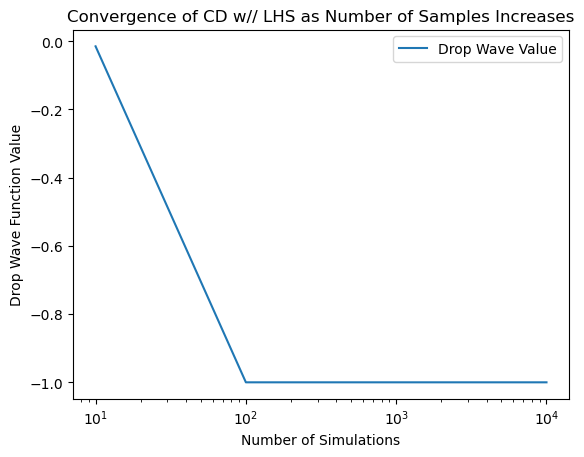

In [9]:
# Plotting
cd_plot['i'] = np.arange(len(cd_plot))
cd_plot.index.name = "Number of Simulations"
cd_plot.reset_index(inplace = True)
plt.plot(cd_plot['Number of Simulations'], cd_plot['Drop Wave Value'], label = "Drop Wave Value")
plt.xticks(sample_sizes)
plt.xscale("log")
plt.legend()
plt.title("Convergence of CD w// LHS as Number of Samples Increases")
plt.xlabel("Number of Simulations")
plt.ylabel("Drop Wave Function Value")

In [10]:
# Outputs dataframe
outputs_sd = pd.DataFrame(columns = ["Drop Wave Value"])

# Looping through all sample sizes
for i in sample_sizes:
    sample = sampler.random(n = i)
    sample_scaled = qmc.scale(sample, lb, ub)
    results = []
    for x0 in sample_scaled:
        result = steepest_descent(drop_wave, x0, gradient_drop_wave)
        # Compute output value of drop_wave
        output = drop_wave(result.x)
        # Store value in results
        results.append(output)
    # Find minimum output value
    min_output = min(results)
    # Storing in output dataframe
    outputs_sd.loc[i, 'Drop Wave Value'] = min_output

outputs_sd


/Users/arjunshah/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/arjunshah/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/arjunshah/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/arjunshah/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/arjunshah/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py

,Drop Wave Value
10,-0.369123
100,-0.185811
1000,-0.999998
10000,-1.0


Text(0, 0.5, 'Drop Wave Function Value')

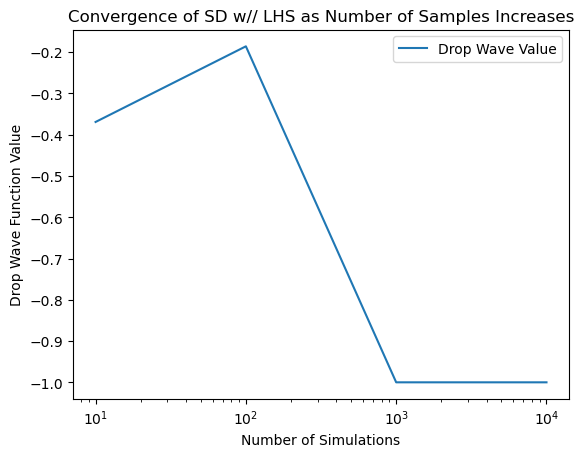

In [11]:
sd_plot = outputs_sd

# Plotting
sd_plot['i'] = np.arange(len(sd_plot))
sd_plot.index.name = "Number of Simulations"
sd_plot.reset_index(inplace = True)
plt.plot(sd_plot['Number of Simulations'], sd_plot['Drop Wave Value'], label = "Drop Wave Value")
plt.xticks(sample_sizes)
plt.xscale("log")
plt.legend()
plt.title("Convergence of SD w// LHS as Number of Samples Increases")
plt.xlabel("Number of Simulations")
plt.ylabel("Drop Wave Function Value")

When comparing the charts of SD and CD w// LHS, we can see the relative outperformance of the CD algorithm as the sample size increases. This suggests that CD is more efficient than SD at find the global minima of highly complex functions. 

# Implementation of Particle Swarm Optimisation (PSO)


As another possible solution to the problem of requiring an initial starting position, we suggest using the PSO algorithm as it doesn't rely on an initial starting position but rather a certain number of particles placed on the Euclidan plane. 

PSO is a population-based optimisation algorithm that is inspired by the social behaviour of birds flocking or fish schooling. In PSO, a population of candidate solutions, called particles, moves through the search space to find the optimal solution. Each particle adjusts its position based on its own experience and the experience of its neighbors. 

We use the pyswarms package to implement this algorithm. Within this function, the algorithm has these steps:
1. Initialize Population: Generate an initial population of particles with random positions and velocities within the search space.
2. Define Fitness Function: Define a fitness function that evaluates the quality of each particle's position.
3. Set Parameters: Define parameters such as the number of particles, maximum iterations, cognitive and social coefficients, inertia weight, and search space boundaries.
4. Initialize Velocity and Position: Initialize the velocity and position of each particle randomly within the search space.
5. Evaluate Fitness: Evaluate the fitness of each particle using the fitness function.
6. Update Personal Best: Update each particle's personal best position if the current position has a better fitness value.
7. Update Global Best: Update the global best position based on the personal best positions of all particles.
8. Update Velocity and Position: Update the velocity and position of each particle using the following equations:
\begin{align*}
\text{Velocity}_{i}^{t+1} &= w \times \text{Velocity}_{i}^{t} + c1 \times \text{rand1} \times (\text{PersonalBest}_{i} - \text{Position}_{i}^{t}) + c2 \times \text{rand2} \times (\text{GlobalBest} - \text{Position}_{i}^{t}) \\
\text{Position}_{i}^{t+1} &= \text{Position}_{i}^{t} + \text{Velocity}_{i}^{t+1} \\
Where: \\
& \text{Velocity}_{i}^{t+1} \text{: The updated velocity of particle } i \text{ at iteration } t+1 \\
& w \text{: Inertia weight} \\
& \text{Velocity}_{i}^{t} \text{: The velocity of particle } i \text{ at iteration } t \\
& c1 \text{ and } c2 \text{: Cognitive and social coefficients, respectively} \\
& \text{rand1 and rand2: Random values between 0 and 1 generated from a uniform distribution} \\
& \text{PersonalBest}_{i} \text{: Personal best position of particle } i \\
& \text{GlobalBest} \text{: Global best position} \\
& \text{Position}_{i}^{t} \text{: The position of particle } i \text{ at iteration } t \\
& \text{Position}_{i}^{t+1} \text{: The updated position of particle } i \text{ at iteration } t+1
\end{align*}




The performance of this model is very dependent upon the hyperparameters chosen. There are four particular hyperparameters of interest: 
1. `c1`: Cognitive paramter, this contrls the paricle's tendency to move toward its historical best position
2. `c2`: Social paramter, controls the particle's tendency to move toward the global best position found by the swarm
3. `w`: Inertia parameter, controls the particle's tendency to maintain its current velocity
4. `n_particles`: The number of particles placed on the search space to optimise
5. `n_iterations`: The number of times the algorithm is run

For parameters 1, 2, 3 & 4 we use `pyswarms` inbuilt default values for these hyperparameters. For the `GlobalBestPSO` function (which is the one we will be implementing) the default values are the following:
1. `c1` = 0.5
2. `c2` = 0.3
3. `w` = 0.9
4. `n_particles` = 1000

These default values are chosen to provide a balanced exploration-exploitation trade-off in the optimization process. 

#### Motivation to compare CD and SD w// LHS with the number of iterations within PSO
The `n_iterations` parameter could be compared to the number of LHS samples chosen. Where as the number of iterations increases, the likelihood of find the global minima increases. Moreover, the algorithm is being run multiple times which is comparable to the having SD and CD being run multiple times for each sample created using LHS. Hence, as with the number of LHS samples, we will highlight the convergence of this algorithm to the global minima as the `n_iterations` parameter increases. 


Too keep consistent with the sampling from LHS, we select the bounds on which these particles can be placed as [-50, 50] for all parameters. 

In [12]:
import numpy as np
import pyswarms as ps

# Define the drop wave function
def drop_wave(x):
    numerator = -1 - np.cos(12 * np.sqrt(x[:, 0]**2 + x[:, 1]**2))
    denominator = 0.5 * (x[:, 0]**2 + x[:, 1]**2) + 2
    return numerator / denominator

# Define the bounds for the optimization problem
lb = [-50, -50]  # Lower bounds
ub = [50, 50]    # Upper bounds
bounds = (lb, ub)

# Set up the optimizer
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

# Outputs dataframe
outputs_pso = pd.DataFrame(columns = ["Drop Wave Value"])

# Looping through all sample sizes
for i in sample_sizes:
    # Perform and Store Optimisation
    optimiser = ps.single.GlobalBestPSO(n_particles = 1000, dimensions = 2, options = options, bounds = bounds)
    best_position, best_value = optimiser.optimize(drop_wave, iters= i)
    
    # Saving output
    outputs_pso.loc[i, "Drop Wave Value"] = best_position
    
outputs_pso

2024-05-29 17:56:24,731 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████|10/10, best_cost=-.989
2024-05-29 17:56:24,771 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9893292460793546, best pos: [-0.006412   -0.01594717]
2024-05-29 17:56:24,783 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|████████████████████████|100/100, best_cost=-1
2024-05-29 17:56:24,889 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9999998820573511, best pos: [-1.63294677e-05 -5.46528950e-05]
2024-05-29 17:56:24,893 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████|1000/1000, best_cost=-1
2024-05-29 17:56:25,855 - pyswarms.single.global_best - INFO - Opti

,Drop Wave Value
10,-0.989329
100,-1.0
1000,-1.0
10000,-1.0


Text(0, 0.5, 'Drop Wave Function Value')

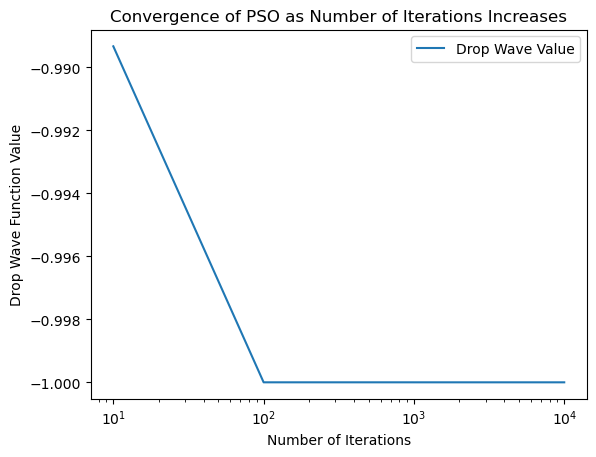

In [13]:
pso_plot = outputs_pso

# Plotting
pso_plot['i'] = np.arange(len(pso_plot))
pso_plot.index.name = "Number of Simulations"
pso_plot.reset_index(inplace = True)
plt.plot(pso_plot['Number of Simulations'], pso_plot['Drop Wave Value'], label = "Drop Wave Value")
plt.xticks(sample_sizes)
plt.xscale("log")
plt.legend()
plt.title("Convergence of PSO as Number of Iterations Increases")
plt.xlabel("Number of Iterations")
plt.ylabel("Drop Wave Function Value")

We can see that PSO gets far closer than CD or SD with LHS for initial starting positions, even with a limited number of particles. 
Furthermore, PSO is vastly more efficient and runs substantially quicker than using CD or SD repeatedly for LHS generated samples. 

# Conclusion

Throughout this project, we have conducted a comparative analysis of optimization algorithms applied to the drop-wave function, focusing on their ability to discover the global minimum.

When pitting the CD and SD methods combined with LHS against each other, the CD algorithm stands out for its rapid convergence to the global minimum as the sample size increases.

However, PSO emerges as the clear winner when considering accuracy, computational efficiency, and ease of implementation. Unlike SD and CD methods, PSO excels in swiftly converging to the global minimum, even with minimal iterations. This efficiency is attributed to its parallel movement of particles in Euclidean space and its independence from the gradient of the objective function.

Moreover, PSO significantly outperforms SD and CD with LHS in terms of computational efficiency, especially as the sample size escalates. Even with a large number of iterations, PSO maintains its computational advantage.

Beyond this, PSO also has a simplicity in implementation, particularly with the availability of user-friendly packages like `pyswarms`. In contrast, SD and CD methods require us to program the algorithm's manually and the incorporation of a Latin hypercube sampler, adding complexity to their implementation.

In summary, this project underscores the superiority of the PSO algorithm over SD and CD (when coupled with LHS) in global optimization tasks on complex geometric landscapes. PSO not only excels in accuracy but also demonstrates superior computational efficiency and ease of implementation, making it a compelling choice for optimization endeavors.

# <p style="text-align: center;">Aside 1: A Motivation for using Latin Hypercube Sampling vs Simple Random Sampling</p>

Instead of using Latin Hypercube Sampling, a sampling methodology which samples an even amount across partitions, we could use completely random sampling in the chosen bounds (in our case it would [50,50] for both variables). In order to simulate this we can sample from the uniform distribution via the `numpy` function `np.random.uniform`. 

Below is code that looks at the optimisation performance using the Steepest Descent algorithm with uniform random sampling, but note that this same result will be applicable for conjugate direction as well.

In [14]:
import autograd.numpy as np

# Define the Drop Wave function
def drop_wave(x):
    numerator = 1 + np.cos(12 * np.sqrt(x[0]**2 + x[1]**2))
    denominator = 0.5 * (x[0]**2 + x[1]**2) + 2
    return -numerator / denominator

# Define the gradient of the Drop Wave function using autograd
gradient_drop_wave = grad(drop_wave)

# Set the seed for reproducibility
np.random.seed(1)

# Outputs dataframe
outputs_sd_rand = pd.DataFrame(columns = ["Drop Wave Value"])

# Looping through all sample sizes
for i in sample_sizes:
    sample = np.random.uniform(-50, 50, size = (i, 2))
    # sample = sampler.random(n = i)
    # Reshape samples into 1d array 
    sample_scaled = sample
    # print(type(sample_scaled))
    # print(sample_scaled)
    # sampled_scaled = qmc.scale(sample, lb, ub)
    results = []
    for x0 in sample_scaled:
        # print((x0))
        result = steepest_descent(drop_wave, x0, gradient_drop_wave)
        # Compute output value of drop_wave
        output = drop_wave(result.x)
        # Store value in results
        results.append(output)
    # Find minimum output value
    min_output = min(results)
    # Storing in output dataframe
    outputs_sd_rand.loc[i, 'Drop Wave Value'] = min_output

# Displaying results 
outputs_sd_rand

/Users/arjunshah/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/arjunshah/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/arjunshah/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/arjunshah/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/arjunshah/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py

,Drop Wave Value
10,-0.03883
100,-0.043101
1000,-0.936238
10000,-1.0


In [15]:
print("Result from using Uniform Random Sampling")
print(outputs_sd_rand)

print("Result from Using LHS")
print(outputs_sd)

Result from using Uniform Random Sampling
      Drop Wave Value
10           -0.03883
100         -0.043101
1000        -0.936238
10000            -1.0
Result from Using LHS
   Number of Simulations Drop Wave Value  i
0                     10       -0.369123  0
1                    100       -0.185811  1
2                   1000       -0.999998  2
3                  10000            -1.0  3


We can see from the above comparison that LHS outperforms uniform random sampling as the drop wave value function converges quicker to the global minimum of -1. 

This justifies our use of LHS over uniform/simple random sampling. 

# <p style="text-align: center;">Aside 2 : PSO's performance on two other optimisation functions</p>

As an exercise of optimisation we apply the PSO algorithm to two other 3-dimensional functions with a large amount of local minima. This is purely as a test of it's performance. 

The two functions are the following: 
1. De Jong Function No. 5  
2. Schaffer Function N. 4


### De Jong Function No. 5

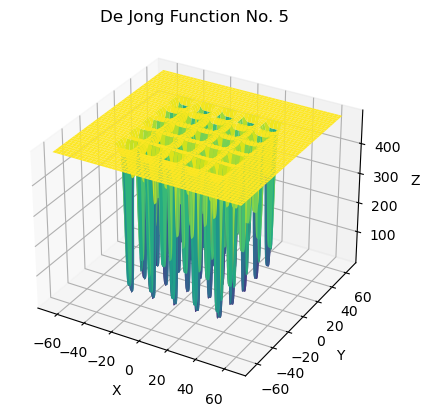

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Constants for the De Jong Function No. 5
a = np.array([
    [-32, -16, 0, 16, 32, -32, -16, 0, 16, 32, -32, -16, 0, 16, 32, -32, -16, 0, 16, 32, -32, -16, 0, 16, 32],
    [-32, -32, -32, -32, -32, -16, -16, -16, -16, -16, 0, 0, 0, 0, 0, 16, 16, 16, 16, 16, 32, 32, 32, 32, 32]
]).T

# Define the De Jong Function No. 5 with a single array input
def de_jong_function_5(x):
    sum_val = 0.0
    for i in range(25):
        sum_val += 1.0 / (i + 1 + (x[:, 0] - a[i, 0])**6 + (x[:, 1] - a[i, 1])**6)
    return (1 / (1/500 + sum_val))

# Generate grid data for visualization
x_range = np.linspace(-65, 65, 400)
y_range = np.linspace(-65, 65, 400)
x, y = np.meshgrid(x_range, y_range)
points = np.c_[x.ravel(), y.ravel()]

# Compute the function values
z = de_jong_function_5(points).reshape(x.shape)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='viridis')

# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('De Jong Function No. 5')

plt.show()


In [17]:
optimiser = ps.single.GlobalBestPSO(n_particles = 1000, dimensions = 2, options = options, bounds = bounds)
best_position, best_value = optimiser.optimize(de_jong_function_5, iters= 1000)

print(best_position, best_value)

2024-05-29 17:57:54,715 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████|1000/1000, best_cost=0.998
2024-05-29 17:57:57,051 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.9980038377944493, best pos: [-31.9783337 -31.9783349]


0.9980038377944493 [-31.9783337 -31.9783349]


The global minimum for the De Jong Function No. 5 is located at approximately $(𝑥_1,𝑥_2) = (−32,−32)$, with a function value of around $𝑓(𝑥_1,𝑥_2)≈0.998. We see that PSO performs well here, getting to the global minima

### Schaffer Function N. 4

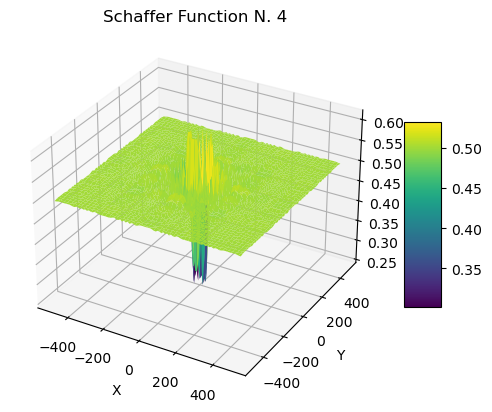

In [35]:
# Define the Schaffer Function N. 4
def schaffer_func(X):
    x, y = X[0], X[1]  # Extract x and y from the 1D array X
    return 0.5 + (np.sin(x**2 + y**2)**2 - 0.5) / (1 + 0.001 * (x**2 + y**2))

# Generate x, y values
x = np.linspace(-500, 500, 100)
y = np.linspace(-500, 500, 100)
x, y = np.meshgrid(x, y)
z = schaffer_func([x, y])

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, cmap='viridis')

# Add color bar which maps values to colors
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(x, y)')
ax.set_title('Schaffer Function N. 4')

plt.show()

In [36]:
# Bounds are reset
lb = [-50, -50]  # Lower bounds
ub = [50, 50]    # Upper bounds
bounds = (lb, ub)

# Set up optimiser
optimiser = ps.single.GlobalBestPSO(n_particles = 1000, dimensions = 2, options = options, bounds = bounds)

def schaffer_func(X):
    x, y = X[:, 0], X[:, 1]  # Extract x and y from the 2D array X
    return np.array([0.5 + (np.sin(x_i**2 + y_i**2)**2 - 0.5) / (1 + 0.001 * (x_i**2 + y_i**2)) for x_i, y_i in zip(x, y)])

best_position, best_value = optimiser.optimize(schaffer_func, iters= 1000)

print(best_position, best_value)

2024-05-29 18:04:21,011 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████|1000/1000, best_cost=0
2024-05-29 18:04:25,055 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [1.27918781e-07 1.55619559e-07]


0.0 [1.27918781e-07 1.55619559e-07]


We can see that the algorithm performs well. The global minimum is 0.0 with ($x_1 = 0, x_2 = 0$) and we can see that PSO does indeed find these values. 